In [24]:
from collections import defaultdict
import get_vpc_corpus
import numpy as np


# Merge any verbs that have the same stem.
VERB_TO_COUNT = defaultdict(int)
for verb, value in get_vpc_corpus.SEED_VERBS.items():
    VERB_TO_COUNT[get_vpc_corpus.get_stem(verb)] += value


def load_vpc_to_year(data_path="vpc_corpus.csv", vpc_vocab=None):
    vpc_to_year = {}
    with open(data_path, "r") as f: 
        for line in f:
            line = line.split() 
            curr_vpc = (line[0], line[1])
            if vpc_vocab is not None and curr_vpc not in vpc_vocab:
                continue
            first_occurrence = int(line[3])
            vpc_to_year[curr_vpc] = first_occurrence
    return vpc_to_year


def load_particle_to_count(data_path="vpc_corpus.csv"):
    particle_to_count = defaultdict(int)
    with open(data_path, "r") as f: 
        for line in f:
            line = line.split() 
            curr_particle = line[1]
            frequency = int(line[2])
            particle_to_count[curr_particle] += frequency
    return particle_to_count


def normalize_dict(d):
    max_val = np.max(list(d.values()))
    return {k: v / max_val for k, v in d.items()}


PARTICLE_TO_COUNT = normalize_dict(load_particle_to_count())
VERB_TO_COUNT = normalize_dict(VERB_TO_COUNT)
POSSIBLE_VPCS = set([(verb, particle) for verb in VERB_TO_COUNT
                     for particle in PARTICLE_TO_COUNT])
VPC_TO_YEAR = load_vpc_to_year(vpc_vocab=POSSIBLE_VPCS)


In [17]:
from tqdm import tqdm
from collections import defaultdict
import pickle
import get_vpc_corpus


def load_verb_to_year_counts(data_path="verb_counts.csv"):
    # This is for frequency-based prediction measures.
    # It's important to maintain all verbs in verb_counts.csv.
    verb_to_year_counts = defaultdict(lambda: defaultdict(int))
    with open(data_path, "r") as f: 
        for line in tqdm(f):
            line = line.split() 
            verb = line[0]
            for item in line[3:]:
                year, count = item.split(",")
                verb_to_year_counts[get_vpc_corpus.get_stem(verb)][int(year)] += int(count)
    return verb_to_year_counts


def load_particle_to_year_counts(data_path="vpc_corpus.csv"):
    # This is for frequency-based prediction measures.
    # It's important to maintain all verbs in verb_counts.csv.
    particle_to_year_counts = defaultdict(lambda: defaultdict(int))
    with open(data_path, "r") as f: 
        for line in tqdm(f):
            line = line.split() 
            curr_particle = line[1]
            for item in line[4:]:
                year, count = item.split(",")
                particle_to_year_counts[curr_particle][int(year)] += int(count)
    return particle_to_year_counts


# VERB_TO_YEAR_COUNTS = load_verb_to_year_counts()
# with open("verb_to_year_counts.pickle", "wb") as f:
#     pickle.dump(dict(VERB_TO_YEAR_COUNTS), f)

# PARTICLE_TO_YEAR_COUNTS = load_particle_to_year_counts()
# with open("particle_to_year_counts.pickle", "wb") as f:
#     pickle.dump(dict(PARTICLE_TO_YEAR_COUNTS), f)


with open("verb_to_year_counts.pickle", "rb") as f:
    VERB_TO_YEAR_COUNTS = pickle.load(f)

with open("particle_to_year_counts.pickle", "rb") as f:
    PARTICLE_TO_YEAR_COUNTS = pickle.load(f)


In [35]:
# Frequency-based ranking. -- decade-specific



def get_verb_particle_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return (
        {x: (VERB_TO_YEAR_COUNTS[x[0]].get(year, 0) *
             PARTICLE_TO_YEAR_COUNTS[x[1]].get(year, 0))
         for x in novel_vpcs},
        "Verb Frequency * Prt Frequency")


def get_verb_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: VERB_TO_YEAR_COUNTS[x[0]].get(year, 0)
            for x in novel_vpcs}, "Verb Frequency")


def get_particle_frequency_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: PARTICLE_TO_YEAR_COUNTS[x[1]].get(year, 0)
            for x in novel_vpcs}, "Prt Frequency")


def get_verb_in_vpc_ranking(known_vpcs, year):
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    verb_to_n_vpcs = defaultdict(int)
    for curr_verb, _ in known_vpcs:
        verb_to_n_vpcs[curr_verb] += 1
    return ({x: verb_to_n_vpcs[x[0]]
            for x in novel_vpcs},
            "#VPCs containing V")


In [41]:
# Neighbor-based ranking.


import pickle
import numpy as np
from tqdm import trange, tqdm
from sklearn.metrics.pairwise import cosine_similarity


def build_mini_verb_dataset(
        start_decade=1800, end_decade=2000, output_path="verb_vectors"):
    # find all vectors for verbs in VERB_TO_COUNT
    # write them to output_path
    for year in trange(start_decade, end_decade, 10):
        with open(f"sgns/{year}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        curr_vectors = np.load(f"sgns/{year}-w.npy")
        verb_vocab = [item for item in curr_vocab if item in VERB_TO_COUNT]
        verb_embeddings = np.array([
            curr_vectors[i] for i, label in enumerate(curr_vocab)
            if label in VERB_TO_COUNT
        ])
        with open(f"verb_vectors/{year}-vocab.pkl", "wb") as f:
            pickle.dump(verb_vocab, f)
        np.save(f"verb_vectors/{year}-w.npy", verb_embeddings)


def compute_nearest_vpc_verbs_prototype(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="nearest_neighbors_prototype.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        # TODO: load vectors from verb_vectors dir for this year
        with open(f"{data_path}/{year}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        verb_to_idx = {verb: i for i, verb in enumerate(curr_vocab)}
        curr_vectors = np.load(f"{data_path}/{year}-w.npy")
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
        
        # 2. Compute particle vectors as the mean of all verb vectors for
        # verbs that occur with a given particle vector.
        particles = list(PARTICLE_TO_COUNT.keys())
        particle_to_idx = {prt: i for i, prt in enumerate(particles)}
        particle_vectors = np.array([
            np.mean([
                curr_vectors[verb_to_idx[verb]]
                for verb in prt_to_verbs[particle]
                if verb in verb_to_idx], axis=0) 
            for particle in particles])
        
        # 3. For each V+prt pair, compute the distance between the V and
        # the particle vector for prt.
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            # find cosine_similarity between verb vector and particle vector
            if curr_verb not in verb_to_idx:
                continue
            verb_vec = curr_vectors[verb_to_idx[curr_verb]]
            prt_vec = particle_vectors[particle_to_idx[curr_prt]]
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = cosine_similarity(
                [verb_vec], [prt_vec])[0][0]

        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)

    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_neighbor_ranking(
        known_vpcs, year, data_path="nearest_neighbors_prototype.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: year_to_possible_vpcs[year].get(x, -1)
            for x in novel_vpcs},
            "Nearest neighbors prototype")


# build_mini_verb_dataset()
# compute_nearest_vpc_verbs_prototype()

In [42]:
def compute_nearest_vpc_verbs_exemplar(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="nearest_neighbors_exemplar.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        # TODO: load vectors from verb_vectors dir for this year
        with open(f"{data_path}/{year}-vocab.pkl", "rb") as f: 
            curr_vocab = pickle.load(f)
        verb_to_idx = {verb: i for i, verb in enumerate(curr_vocab)}
        curr_vectors = np.load(f"{data_path}/{year}-w.npy")
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
        
        # 2. Compute particle vectors as the mean of all verb vectors for
        # verbs that occur with a given particle vector.
        particles = list(PARTICLE_TO_COUNT.keys())
        particle_to_idx = {prt: i for i, prt in enumerate(particles)}
        particle_vectors = {particle: np.array(
            [curr_vectors[verb_to_idx[verb]]
             for verb in prt_to_verbs[particle]
             if verb in verb_to_idx])
            for particle in particles}
        
        # 3. For each V+prt pair, compute the distance between the V and
        # the particle vector for prt.
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            # find cosine_similarity between verb vector and particle vector
            if curr_verb not in verb_to_idx:
                continue
            verb_vec = curr_vectors[verb_to_idx[curr_verb]]
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = np.max(cosine_similarity(
                [verb_vec], particle_vectors[curr_prt]))

        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)

    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_neighbor_ranking_exemplar(
        known_vpcs, year, data_path="nearest_neighbors_exemplar.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: year_to_possible_vpcs[year].get(x, -1)
            for x in novel_vpcs},
            "Nearest neighbors exemplar")


#compute_nearest_vpc_verbs_exemplar()

In [44]:
with open("levin_1993_data.p", "rb") as f: 
    LEVIN_VERBS = pickle.load(f)[0]
    LEVIN_VERBS = {k: set(v) for k, v in LEVIN_VERBS.items()}
LEVIN_VERB_LIST = list(LEVIN_VERBS.keys())
LEVIN_VERB_TO_IDX = {v: i for i, v in enumerate(LEVIN_VERB_LIST)}
LEVIN_DISTANCES = np.array([[
    len(LEVIN_VERBS[verb1].intersection(LEVIN_VERBS[verb2])) /
    len(LEVIN_VERBS[verb1].union(LEVIN_VERBS[verb2]))
    for verb1 in LEVIN_VERB_LIST]
    for verb2 in LEVIN_VERB_LIST])


def get_ranking_levin_verbs(
        known_vpcs, year, data_path="nearest_neighbors_exemplar.pickle"):    
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    prt_to_verbs = defaultdict(set)
    for v, prt in known_vpcs:
        prt_to_verbs[prt].add(v)
    
    return ({x: np.max([
            LEVIN_DISTANCES[LEVIN_VERB_TO_IDX[verb], LEVIN_VERB_TO_IDX[x[0]]]
            for verb in prt_to_verbs[x[1]]
            if verb in LEVIN_VERBS]) if x[0] in LEVIN_VERBS else 0
            for x in novel_vpcs},
            "Levin verbs exemplar")

In [45]:
# Phonological neighbor-based ranking

from tqdm import tqdm, trange
import Levenshtein
import pickle


def compute_nearest_vpc_verbs_phonological_prototype(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="phonological_nearest_neighbors_prototype.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    verb_vocab = list(VERB_TO_COUNT.keys())
    verb_to_idx = {verb: i for i, verb in enumerate(verb_vocab)}
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
            
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            mean_sim = np.mean([
                Levenshtein.ratio(curr_verb, prt_verb)
                for prt_verb in prt_to_verbs[curr_prt]])
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = mean_sim
        
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)
        
    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)
        
        
def compute_nearest_vpc_verbs_phonological_exemplar(
        start_decade=1800, end_decade=2000, data_path="verb_vectors",
        output_path="phonological_nearest_neighbors_exemplar.pickle"):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    verb_vocab = list(VERB_TO_COUNT.keys())
    verb_to_idx = {verb: i for i, verb in enumerate(verb_vocab)}
    
    year_to_possible_vpcs = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        
        # 1. Find all verbs that occur with each particle
        prt_to_verbs = defaultdict(set)
        for v, prt in known_vpcs:
            prt_to_verbs[prt].add(v)
            
        curr_possible_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
        for curr_verb, curr_prt in curr_possible_vpcs:
            max_sim = np.max([
                Levenshtein.ratio(curr_verb, prt_verb)
                for prt_verb in prt_to_verbs[curr_prt]])
            year_to_possible_vpcs[year][(curr_verb, curr_prt)] = max_sim
        
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        known_vpcs.update(novel_vpcs)
        
    with open(output_path, "wb") as f:
        pickle.dump(year_to_possible_vpcs, f)


def get_phonological_neighbor_ranking(
        known_vpcs, year,
        data_path="phonological_nearest_neighbors_exemplar.pickle"):
    with open(data_path, "rb") as f:
        year_to_possible_vpcs = pickle.load(f)
    novel_vpcs = POSSIBLE_VPCS.difference(known_vpcs)
    return ({x: year_to_possible_vpcs[year][x]
            for x in novel_vpcs},
            "phonological exemplar")

        
#compute_nearest_vpc_verbs_phonological_prototype()
#compute_nearest_vpc_verbs_phonological_exemplar()

100%|██████████| 101/101 [00:00<00:00, 177.86it/s]


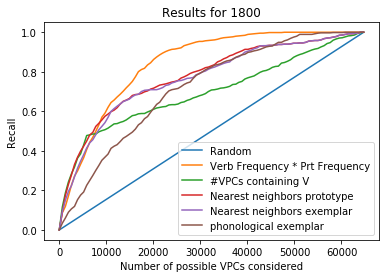

100%|██████████| 101/101 [00:00<00:00, 197.91it/s]


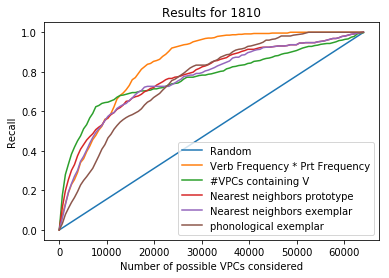

100%|██████████| 101/101 [00:00<00:00, 256.58it/s]


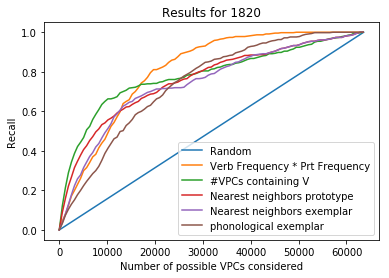

100%|██████████| 101/101 [00:00<00:00, 177.61it/s]


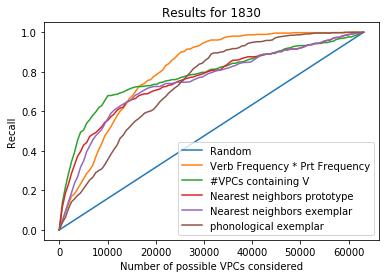

100%|██████████| 101/101 [00:00<00:00, 248.09it/s]


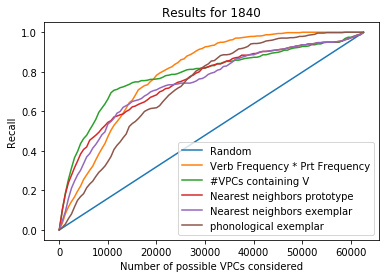

100%|██████████| 101/101 [00:00<00:00, 247.92it/s]


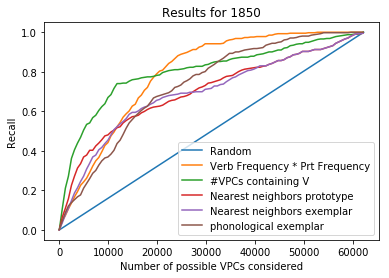

100%|██████████| 101/101 [00:00<00:00, 247.33it/s]


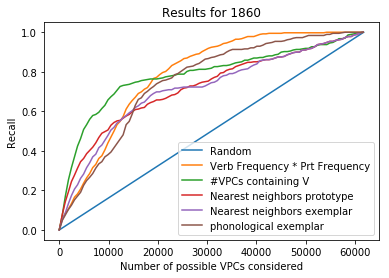

100%|██████████| 101/101 [00:00<00:00, 223.32it/s]


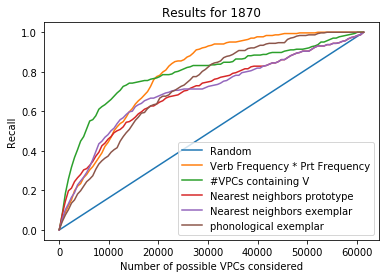

100%|██████████| 101/101 [00:00<00:00, 317.37it/s]


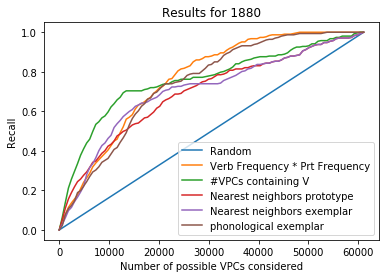

100%|██████████| 101/101 [00:00<00:00, 182.02it/s]


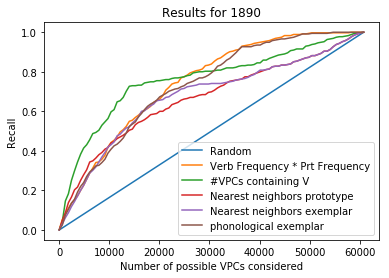

100%|██████████| 101/101 [00:00<00:00, 236.82it/s]


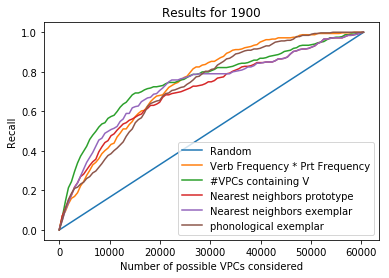

100%|██████████| 101/101 [00:00<00:00, 243.42it/s]


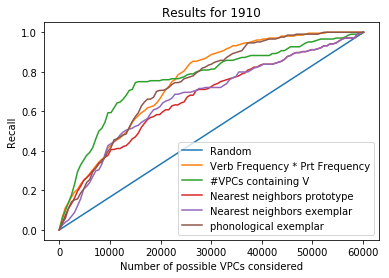

100%|██████████| 101/101 [00:00<00:00, 231.61it/s]


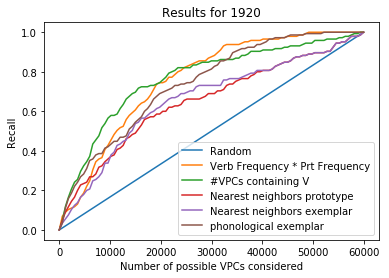

100%|██████████| 101/101 [00:00<00:00, 213.43it/s]


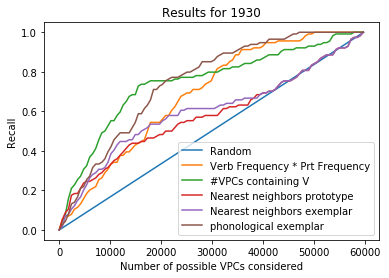

100%|██████████| 101/101 [00:00<00:00, 175.04it/s]


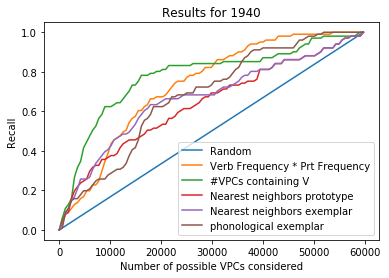

100%|██████████| 101/101 [00:00<00:00, 261.78it/s]


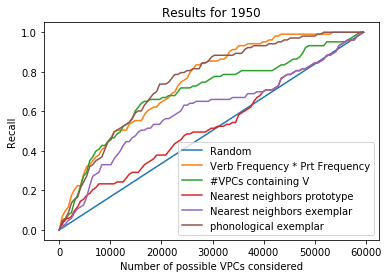

100%|██████████| 101/101 [00:00<00:00, 236.11it/s]


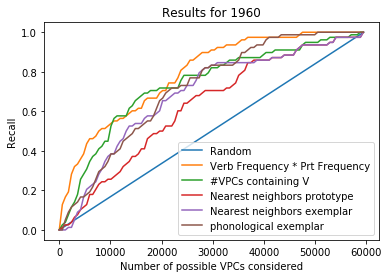

100%|██████████| 101/101 [00:00<00:00, 242.68it/s]


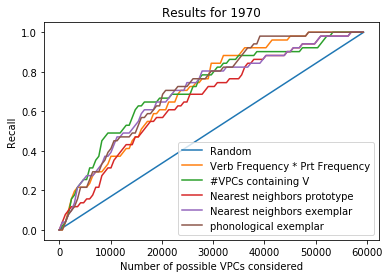

100%|██████████| 101/101 [00:00<00:00, 250.26it/s]


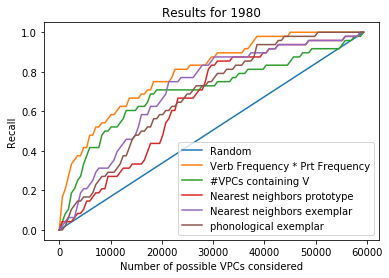

100%|██████████| 101/101 [00:00<00:00, 254.88it/s]


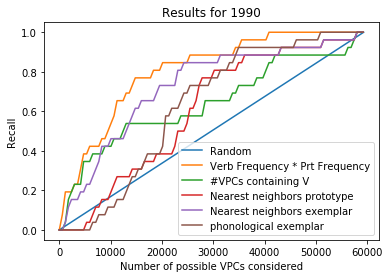

In [46]:
import matplotlib.pyplot as plt
from tqdm import tqdm


def evaluate_vpcs(novel_vpcs, ranking, ranking_name=None):
    for item in novel_vpcs:
        assert item in ranking, f"{item} not in ranking"
    n_vpcs = list(range(1, len(ranking), len(ranking) // 100))
    recall = []
    for i in tqdm(n_vpcs):
        curr_n_correct = len([item for item in ranking[:i] if item in novel_vpcs])
        recall.append(curr_n_correct / len(novel_vpcs))
    plt.plot(n_vpcs, recall, label=ranking_name)
    
    
def get_rank_list(word_to_score):
    words = list(word_to_score.keys())
    return sorted(words, key=lambda x: word_to_score[x], reverse=True)

    
def run_experiment(ranking_functions, start_decade=1800, end_decade=2000):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    
    for year in range(start_decade, end_decade, 10):
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        plt.plot([0, len(POSSIBLE_VPCS) - len(known_vpcs)], [0, 1], label="Random")
        for ranking_function in ranking_functions:
            ranking, ranking_name = ranking_function(known_vpcs, year)
            ranking = get_rank_list(ranking)
            evaluate_vpcs(novel_vpcs, ranking, ranking_name=ranking_name)    
        plt.xlabel("Number of possible VPCs considered")
        plt.ylabel("Recall")
        plt.legend()
        plt.title(f"Results for {year}")
        plt.show()
        known_vpcs.update(novel_vpcs)


run_experiment(
    [get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking])

100%|██████████| 101/101 [00:00<00:00, 216.50it/s]


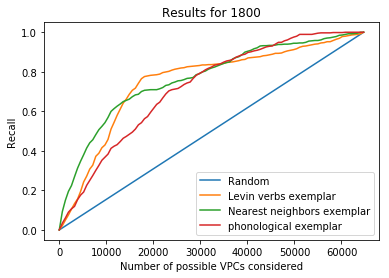

100%|██████████| 101/101 [00:00<00:00, 225.74it/s]


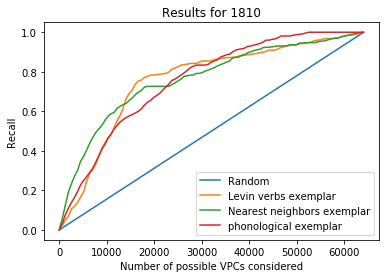

100%|██████████| 101/101 [00:00<00:00, 216.23it/s]


KeyboardInterrupt: 

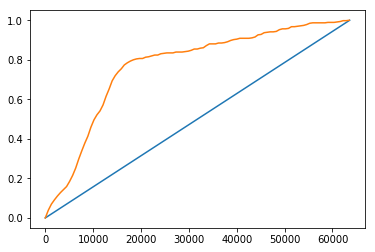

In [49]:
# TODO: In order to have a fair evaluation of the levin verbs method,
# we would need to limit the predictions of the other exemplar methods
# to only select from among levin verbs.

run_experiment(
    [get_ranking_levin_verbs,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking])

100%|██████████| 101/101 [00:00<00:00, 221.47it/s]


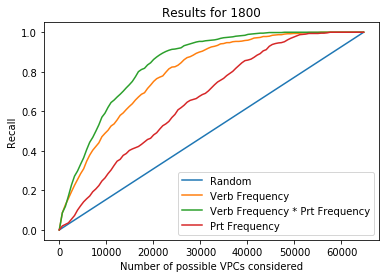

100%|██████████| 101/101 [00:00<00:00, 222.00it/s]


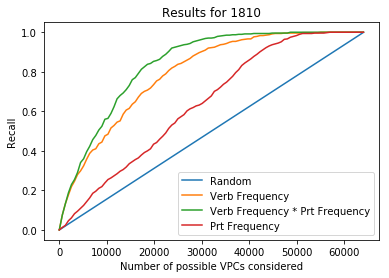

100%|██████████| 101/101 [00:00<00:00, 241.39it/s]


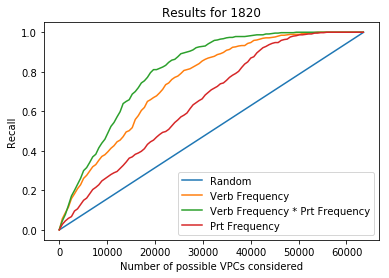

100%|██████████| 101/101 [00:00<00:00, 222.40it/s]


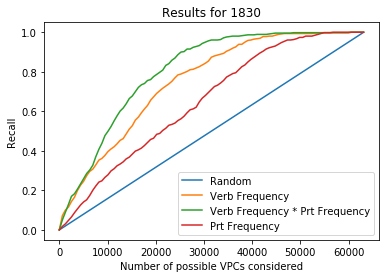

100%|██████████| 101/101 [00:00<00:00, 251.61it/s]


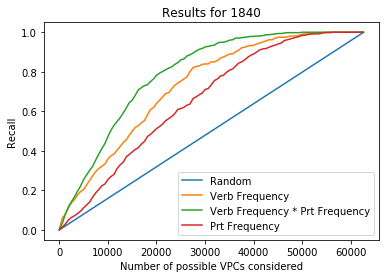

100%|██████████| 101/101 [00:00<00:00, 238.96it/s]


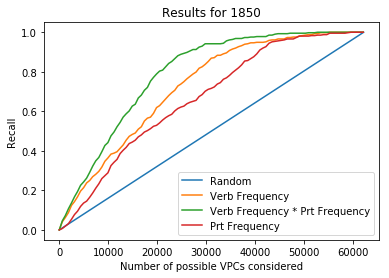

100%|██████████| 101/101 [00:00<00:00, 226.24it/s]


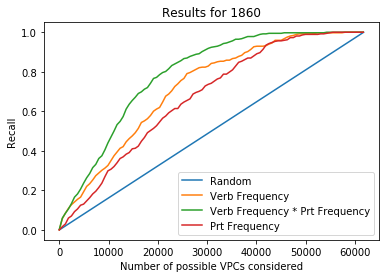

100%|██████████| 101/101 [00:00<00:00, 145.24it/s]


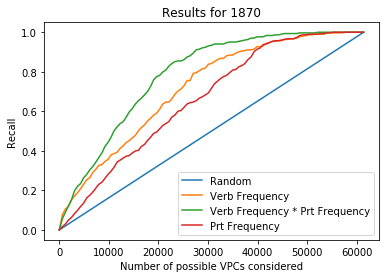

100%|██████████| 101/101 [00:00<00:00, 280.07it/s]


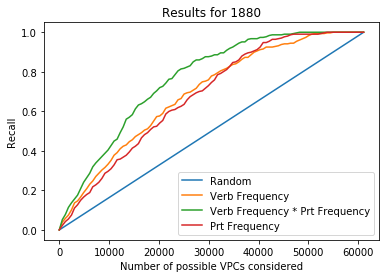

100%|██████████| 101/101 [00:00<00:00, 220.64it/s]


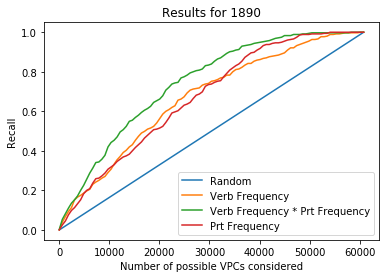

100%|██████████| 101/101 [00:00<00:00, 183.96it/s]


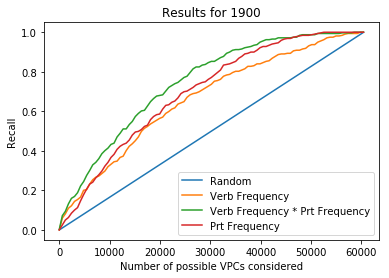

100%|██████████| 101/101 [00:00<00:00, 192.67it/s]


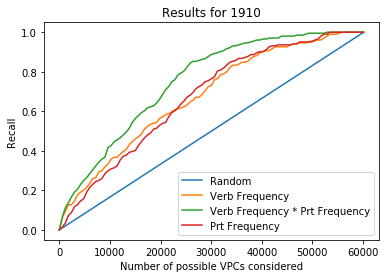

100%|██████████| 101/101 [00:00<00:00, 217.25it/s]


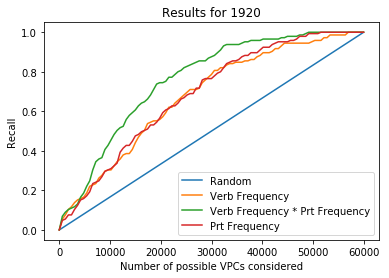

100%|██████████| 101/101 [00:00<00:00, 237.95it/s]


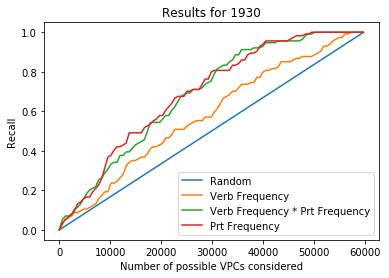

100%|██████████| 101/101 [00:00<00:00, 230.39it/s]


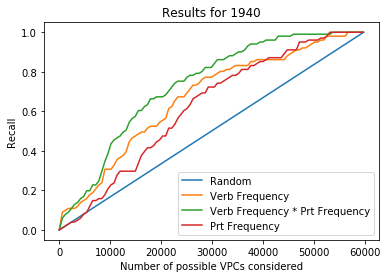

100%|██████████| 101/101 [00:00<00:00, 156.62it/s]


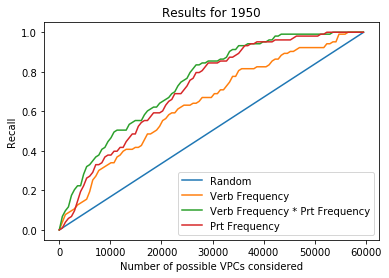

100%|██████████| 101/101 [00:00<00:00, 275.45it/s]


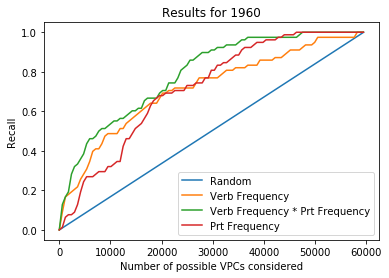

100%|██████████| 101/101 [00:00<00:00, 241.61it/s]


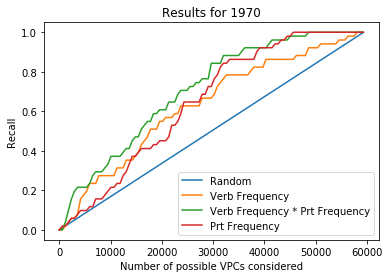

100%|██████████| 101/101 [00:00<00:00, 267.14it/s]


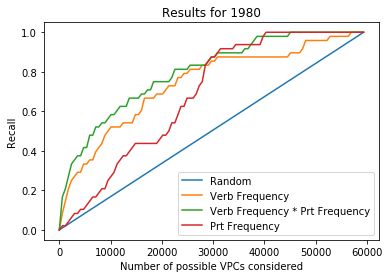

100%|██████████| 101/101 [00:00<00:00, 305.57it/s]


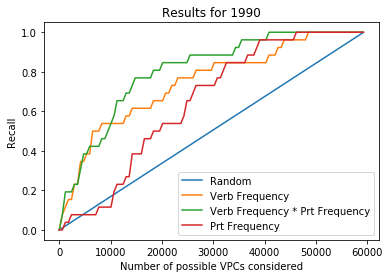

In [39]:
run_experiment(
    [get_verb_frequency_ranking,
     get_verb_particle_frequency_ranking,
     get_particle_frequency_ranking])

# Feature correlations

In [86]:
import scipy.stats
import seaborn as sns


def plot_feature_correlations(
        ranking_functions, start_decade=1800, end_decade=2000,
        plot_style="by_year"  # in {"by_year", "heatmap"}
    ):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    func_to_rankings = defaultdict(dict)
    ranking_names = []
    for year in trange(start_decade, end_decade, 10):
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        for i, ranking_function in enumerate(ranking_functions):
            curr_ranking, ranking_name = ranking_function(known_vpcs, year) 
            func_to_rankings[i][year] = curr_ranking
            if year == start_decade:
                ranking_names.append(ranking_name)
        known_vpcs.update(novel_vpcs)

    if plot_style == "by_year":
        feat_to_correlations = defaultdict(list)
        for year in trange(start_decade, end_decade, 10):
            word_list = list(func_to_rankings[0][year].keys())
            feat0_scores = [func_to_rankings[0][year][curr_word] for curr_word in word_list]
            for feat_i in range(1, len(ranking_functions)):
                feati_scores = [func_to_rankings[feat_i][year][curr_word] for curr_word in word_list]
                corr = scipy.stats.pearsonr(feat0_scores, feati_scores)
                print(year, feat_i, corr)
                feat_to_correlations[feat_i].append(corr[0])

        years = list(range(start_decade, end_decade, 10))
        for feat_i, correlations in feat_to_correlations.items():
            plt.plot(years, correlations, label=ranking_names[feat_i])
        plt.ylim((0, 1))
        plt.legend()
    else:
        years = list(range(start_decade, end_decade, 10))
        feat_correlations = np.empty((len(years), len(ranking_names), len(ranking_functions)))
        for year in trange(start_decade, end_decade, 10):
            word_list = list(func_to_rankings[0][year].keys())
            for feat1 in range(0, len(ranking_functions)):
                feat1_scores = [func_to_rankings[feat1][year][curr_word] for curr_word in word_list]

                for feat2 in range(feat1, len(ranking_functions)):
                    feat2_scores = [func_to_rankings[feat2][year][curr_word] for curr_word in word_list]
                    corr = scipy.stats.pearsonr(feat1_scores, feat2_scores)
                    feat_correlations[years.index(year), feat1, feat2] = corr[0]
                    feat_correlations[years.index(year), feat2, feat1] = corr[0]
        feat_correlations = np.mean(feat_correlations, axis=0)
        print(feat_correlations)
        sns.heatmap(feat_correlations, xticklabels=ranking_names, yticklabels=ranking_names,
                    vmin=0, vmax=1, annot=True)



100%|██████████| 20/20 [02:08<00:00,  6.31s/it]

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


[[1.         0.14011138 0.11843062 0.15196815 0.085377  ]
 [0.14011138 1.         0.21492151 0.19162511 0.00741046]
 [0.11843062 0.21492151 1.         0.97911811 0.05364846]
 [0.15196815 0.19162511 0.97911811 1.         0.08680364]
 [0.085377   0.00741046 0.05364846 0.08680364 1.        ]]


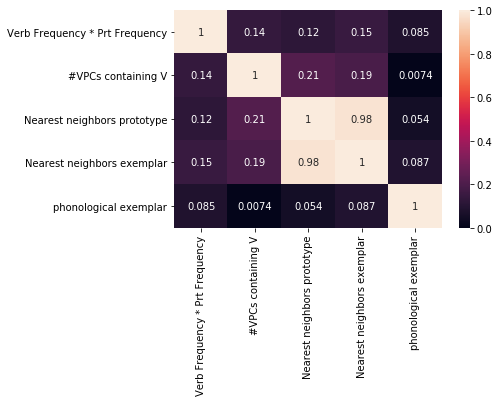

In [87]:
plot_feature_correlations(
    [get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking
    ], plot_style="heatmap")


100%|██████████| 20/20 [02:13<00:00,  6.23s/it]

  5%|▌         | 1/20 [00:00<00:04,  4.36it/s]

1800 1 (0.18519659583091116, 0.0)
1800 2 (0.13249572829735062, 3.2311702484549674e-251)
1800 3 (0.15694509273935942, 0.0)
1800 4 (0.08927042910289901, 1.312033344569899e-114)



 10%|█         | 2/20 [00:00<00:04,  4.30it/s]

1810 1 (0.176855115013538, 0.0)
1810 2 (0.13268559873539904, 1.933161340931911e-249)
1810 3 (0.15875937814623536, 0.0)
1810 4 (0.09186676780580486, 4.32025813892075e-120)



 15%|█▌        | 3/20 [00:00<00:03,  4.28it/s]

1820 1 (0.16176686842871704, 0.0)
1820 2 (0.12440206023164191, 1.1152906211325277e-217)
1820 3 (0.1541644522237127, 0.0)
1820 4 (0.09020141361590839, 5.505886916502239e-115)
1830 1 (0.16731676533679685, 0.0)



 20%|██        | 4/20 [00:00<00:03,  4.22it/s]

1830 2 (0.1287421672954479, 1.9333265122566867e-231)
1830 3 (0.16268202833849862, 0.0)
1830 4 (0.09222870735320861, 2.7326037830693873e-119)
1840 1 (0.15971640765345063, 0.0)



 25%|██▌       | 5/20 [00:01<00:03,  4.31it/s]

1840 2 (0.1295778738707929, 9.190711018338347e-233)
1840 3 (0.16407924377502833, 0.0)
1840 4 (0.09157349171240955, 8.82006773204904e-117)
1850 1 (0.15528108924420164, 0.0)



 30%|███       | 6/20 [00:01<00:03,  4.39it/s]

1850 2 (0.12565017020061986, 3.047015857488697e-217)
1850 3 (0.16131702687370775, 0.0)
1850 4 (0.09132538284965712, 2.710633225366479e-115)
1860 1 (0.15202194467848787, 4.3399543e-316)



 35%|███▌      | 7/20 [00:01<00:03,  4.15it/s]

1860 2 (0.12307529397635653, 4.415517730631022e-207)
1860 3 (0.1572054510063294, 0.0)
1860 4 (0.08966275644751788, 1.8285524079346387e-110)
1870 1 (0.14457354810904402, 4.498303997913787e-284)



 40%|████      | 8/20 [00:01<00:03,  3.96it/s]

1870 2 (0.12391678363302079, 1.1177684981901288e-208)
1870 3 (0.16038733526337176, 0.0)
1870 4 (0.08978258736264529, 4.1567976130311846e-110)
1880 1 (0.14172337198961948, 1.2807292683831757e-271)



 45%|████▌     | 9/20 [00:02<00:02,  3.73it/s]

1880 2 (0.12228048014342698, 3.173181215112493e-202)
1880 3 (0.1551557771550423, 0.0)
1880 4 (0.0889645827511583, 1.2948867157960422e-107)
1890 1 (0.13835939146140372, 1.4475680390999552e-257)



 50%|█████     | 10/20 [00:02<00:02,  4.16it/s]

1890 2 (0.11754838731104984, 5.335505962379355e-186)
1890 3 (0.151401135640958, 1.4257006617982194e-308)
1890 4 (0.08898183695705386, 4.000376396197526e-107)
1900 1 (0.13241141093840086, 1.60831708369498e-234)
1900 2 (0.1180393055282145, 1.8186582512891824e-186)
1900 3 (0.15317821382464225, 4.616919731e-314)



 55%|█████▌    | 11/20 [00:02<00:02,  4.42it/s]

1900 4 (0.0891833988384337, 5.495688903482011e-107)
1910 1 (0.12833166263874082, 3.769081801731378e-219)
1910 2 (0.11770072725846943, 1.9540621294683344e-184)
1910 3 (0.15558966197128904, 2.2e-322)



 60%|██████    | 12/20 [00:02<00:01,  4.45it/s]

1910 4 (0.08671955281820722, 1.0220265278919806e-100)
1920 1 (0.1307712759006215, 8.67948787991639e-227)
1920 2 (0.11637422738266555, 1.0259859472160043e-179)
1920 3 (0.155324383078749, 3.3957e-320)



 70%|███████   | 14/20 [00:03<00:01,  4.63it/s]

1920 4 (0.08596393962308854, 1.1456642213128105e-98)
1930 1 (0.1290955309490558, 1.7288722705761184e-220)
1930 2 (0.1167369803824014, 2.1223240562981934e-180)
1930 3 (0.15575758605171142, 3.21e-321)
1930 4 (0.08517855566465206, 1.1345118485048124e-96)



 75%|███████▌  | 15/20 [00:03<00:01,  4.94it/s]

1940 1 (0.12821833857947618, 4.274168213858844e-217)
1940 2 (0.114923133181929, 1.5559566859881495e-174)
1940 3 (0.1537368224987772, 2.645474699775e-312)
1940 4 (0.08226695178727644, 4.091456209546787e-90)
1950 1 (0.1214162207888708, 2.1367808961432e-194)
1950 2 (0.10900358186937058, 7.41431052380433e-157)



 80%|████████  | 16/20 [00:03<00:00,  4.67it/s]

1950 3 (0.14695506500174207, 8.991228571938755e-285)
1950 4 (0.07922149224768515, 1.5155033010946266e-83)
1960 1 (0.11276512922334762, 1.6507158509730972e-167)
1960 2 (0.10408872095248325, 6.860403402914972e-143)
1960 3 (0.1361959494163006, 4.147313939776927e-244)



 90%|█████████ | 18/20 [00:04<00:00,  5.03it/s]

1960 4 (0.07596477172130756, 8.03964950226526e-77)
1970 1 (0.11102282569979932, 3.413263216021154e-162)
1970 2 (0.10329025268612829, 1.5239058679365265e-140)
1970 3 (0.1353927886738842, 6.359614731668801e-241)
1970 4 (0.07358889454500106, 4.216981882754761e-72)



 95%|█████████▌| 19/20 [00:04<00:00,  5.00it/s]

1980 1 (0.11110726899560663, 2.6649387965204874e-162)
1980 2 (0.10308138488942169, 7.313930371788955e-140)
1980 3 (0.1331711920438497, 6.983922764348156e-233)
1980 4 (0.07229496300951326, 1.3742344294028353e-69)



100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


1990 1 (0.11427682003295869, 1.6913309402351252e-171)
1990 2 (0.10499951263930551, 5.931926436747347e-145)
1990 3 (0.13196442031890124, 1.68845196824933e-228)
1990 4 (0.07329958896783416, 1.967170439934499e-71)


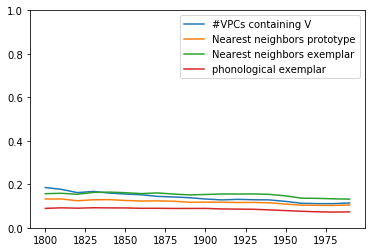

In [88]:
plot_feature_correlations(
    [get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking
    ])

# Run multiple logistic regressions, to see how the features interact

In [93]:
import numpy as np


def pickle_rankings(
        ranking_functions, output_path="regressed_out_freq.pickle",
        start_decade=1800, end_decade=2000,
        plot_style="by_year"  # in {"by_year", "heatmap"}
    ):
    known_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year < start_decade])
    func_to_rankings = defaultdict(dict)
    for year in trange(start_decade, end_decade, 10):
        novel_vpcs = set([
            curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
            if curr_year == year])
        for i, ranking_function in enumerate(ranking_functions):
            curr_ranking, ranking_name = ranking_function(known_vpcs, year) 
            func_to_rankings[ranking_name][year] = curr_ranking
        known_vpcs.update(novel_vpcs)
        
    with open(output_path, "wb") as f:
        pickle.dump(dict(func_to_rankings), f)
    return func_to_rankings


func_to_rankings = pickle_rankings_regress_out_frequency([get_verb_particle_frequency_ranking,
     get_verb_in_vpc_ranking,
     get_neighbor_ranking,
     get_neighbor_ranking_exemplar,
     get_phonological_neighbor_ranking
    ])




  0%|          | 0/20 [00:00<?, ?it/s]


  5%|▌         | 1/20 [00:07<02:28,  7.81s/it]


 10%|█         | 2/20 [00:15<02:17,  7.63s/it]


 15%|█▌        | 3/20 [00:22<02:08,  7.58s/it]


 20%|██        | 4/20 [00:29<02:00,  7.52s/it]


 25%|██▌       | 5/20 [00:37<01:51,  7.44s/it]


 30%|███       | 6/20 [00:44<01:43,  7.40s/it]


 35%|███▌      | 7/20 [00:52<01:37,  7.51s/it]


 40%|████      | 8/20 [00:59<01:30,  7.55s/it]


 45%|████▌     | 9/20 [01:07<01:23,  7.63s/it]


 50%|█████     | 10/20 [01:14<01:15,  7.52s/it]


 55%|█████▌    | 11/20 [01:22<01:06,  7.44s/it]


 60%|██████    | 12/20 [01:29<00:59,  7.42s/it]


 65%|██████▌   | 13/20 [01:36<00:51,  7.38s/it]


 70%|███████   | 14/20 [01:44<00:44,  7.39s/it]


 75%|███████▌  | 15/20 [01:51<00:36,  7.27s/it]


 80%|████████  | 16/20 [01:58<00:28,  7.24s/it]


 85%|████████▌ | 17/20 [02:05<00:21,  7.16s/it]


 90%|█████████ | 18/20 [02:12<00:14,  7.23s/it]


 95%|█████████▌| 19/20 [02:19<00:07,  7.04s/it]


100%|██████████

In [106]:
# Multiple regressions -- 
# Features that are consistently significant:
#   * #VPCs containing V 
#   * Nearest neighbors prototype
#   * phonological exemplar
# Features that often come out as non-significant: 
#   * VPCs containing V and 
#   * Nearest neighbors exemplar

import statsmodels.discrete.discrete_model as sm
import statsmodels.tools.tools
import pandas as pd

start_decade=1800
end_decade=2000
known_vpcs = set([
    curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
    if curr_year < start_decade])
for year in trange(start_decade, end_decade, 10):
    novel_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year == year])
    possible_novel_vpcs = list(POSSIBLE_VPCS.difference(known_vpcs))
    y = np.array([1 if x in novel_vpcs else 0 for x in possible_novel_vpcs])
    X = pd.DataFrame({curr_func: [func_to_rankings[curr_func][year][x] for x in possible_novel_vpcs]
         for curr_func in func_to_rankings})
    X = statsmodels.tools.tools.add_constant(X)
    logit = sm.Logit(y, X)
    result = logit.fit()
    print(result.summary())
    known_vpcs.update(novel_vpcs)






  0%|          | 0/20 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.046274
         Iterations 11







  5%|▌         | 1/20 [00:02<00:38,  2.03s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                64711
Model:                          Logit   Df Residuals:                    64705
Method:                           MLE   Df Model:                            5
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1736
Time:                        18:47:07   Log-Likelihood:                -2994.4
converged:                       True   LL-Null:                       -3623.4
                                        LLR p-value:                8.159e-270
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -8.1594      0.234    -34.884      0.000      -8.618      -7.701
Verb Frequency * Prt Frequency   5.35e-10   8.17e-11      6.545      0.






 10%|█         | 2/20 [00:04<00:38,  2.13s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                64064
Model:                          Logit   Df Residuals:                    64058
Method:                           MLE   Df Model:                            5
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.2043
Time:                        18:47:09   Log-Likelihood:                -2230.2
converged:                       True   LL-Null:                       -2802.8
                                        LLR p-value:                2.219e-245
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -9.7145      0.310    -31.301      0.000     -10.323      -9.106
Verb Frequency * Prt Frequency  1.226e-10   3.96e-11      3.095      0.






 15%|█▌        | 3/20 [00:06<00:37,  2.21s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                63589
Model:                          Logit   Df Residuals:                    63583
Method:                           MLE   Df Model:                            5
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1721
Time:                        18:47:12   Log-Likelihood:                -2256.7
converged:                       True   LL-Null:                       -2725.7
                                        LLR p-value:                1.595e-200
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -9.3369      0.307    -30.376      0.000      -9.939      -8.734
Verb Frequency * Prt Frequency  3.002e-11   1.39e-11      2.161      0.






 20%|██        | 4/20 [00:08<00:35,  2.21s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                63129
Model:                          Logit   Df Residuals:                    63123
Method:                           MLE   Df Model:                            5
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1809
Time:                        18:47:14   Log-Likelihood:                -2225.8
converged:                       True   LL-Null:                       -2717.4
                                        LLR p-value:                2.546e-210
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -9.4628      0.315    -30.088      0.000     -10.079      -8.846
Verb Frequency * Prt Frequency  1.877e-11   7.77e-12      2.415      0.






 25%|██▌       | 5/20 [00:11<00:33,  2.21s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                62670
Model:                          Logit   Df Residuals:                    62664
Method:                           MLE   Df Model:                            5
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1634
Time:                        18:47:16   Log-Likelihood:                -2331.8
converged:                       True   LL-Null:                       -2787.4
                                        LLR p-value:                1.023e-194
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -8.9659      0.303    -29.543      0.000      -9.561      -8.371
Verb Frequency * Prt Frequency  1.063e-11   5.09e-12      2.090      0.






 30%|███       | 6/20 [00:13<00:29,  2.12s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                62196
Model:                          Logit   Df Residuals:                    62191
Method:                           MLE   Df Model:                            4
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1722
Time:                        18:47:18   Log-Likelihood:                -2050.9
converged:                       True   LL-Null:                       -2477.6
                                        LLR p-value:                1.937e-183
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -9.8907      0.345    -28.687      0.000     -10.566      -9.215
Verb Frequency * Prt Frequency  2.979e-12   2.97e-12      1.004      0.






 35%|███▌      | 7/20 [00:15<00:27,  2.14s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61784
Model:                          Logit   Df Residuals:                    61779
Method:                           MLE   Df Model:                            4
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1663
Time:                        18:47:20   Log-Likelihood:                -1877.8
converged:                       True   LL-Null:                       -2252.3
                                        LLR p-value:                8.510e-161
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -10.4489      0.387    -26.977      0.000     -11.208      -9.690
Verb Frequency * Prt Frequency  9.993e-12   2.85e-12      3.509      0.






 40%|████      | 8/20 [00:17<00:25,  2.16s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61416
Model:                          Logit   Df Residuals:                    61411
Method:                           MLE   Df Model:                            4
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1494
Time:                        18:47:22   Log-Likelihood:                -1626.0
converged:                       True   LL-Null:                       -1911.7
                                        LLR p-value:                2.509e-122
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -10.4188      0.419    -24.885      0.000     -11.239      -9.598
Verb Frequency * Prt Frequency  5.045e-12   2.46e-12      2.049      0.






 45%|████▌     | 9/20 [00:19<00:24,  2.20s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61113
Model:                          Logit   Df Residuals:                    61109
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1329
Time:                        18:47:25   Log-Likelihood:                -1674.6
converged:                       True   LL-Null:                       -1931.4
                                        LLR p-value:                5.572e-111
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -10.6657      0.434    -24.596      0.000     -11.516      -9.816
Verb Frequency * Prt Frequency  2.102e-12   1.28e-12      1.638      0.






 50%|█████     | 10/20 [00:22<00:22,  2.30s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60806
Model:                          Logit   Df Residuals:                    60802
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1322
Time:                        18:47:27   Log-Likelihood:                -1891.7
converged:                       True   LL-Null:                       -2179.8
                                        LLR p-value:                1.394e-124
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -10.4800      0.403    -26.016      0.000     -11.270      -9.690
Verb Frequency * Prt Frequency  1.916e-12   7.02e-13      2.728      0.






 55%|█████▌    | 11/20 [00:24<00:21,  2.39s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60451
Model:                          Logit   Df Residuals:                    60447
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1334
Time:                        18:47:30   Log-Likelihood:                -1725.5
converged:                       True   LL-Null:                       -1991.1
                                        LLR p-value:                8.234e-115
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -10.4498      0.428    -24.428      0.000     -11.288      -9.611
Verb Frequency * Prt Frequency  1.534e-12   3.63e-13      4.229      0.






 60%|██████    | 12/20 [00:27<00:19,  2.49s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60132
Model:                          Logit   Df Residuals:                    60128
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1160
Time:                        18:47:33   Log-Likelihood:                -1205.5
converged:                       True   LL-Null:                       -1363.6
                                        LLR p-value:                 2.945e-68
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -11.1464      0.547    -20.367      0.000     -12.219     -10.074
Verb Frequency * Prt Frequency  1.957e-12   5.63e-13      3.477      0.






 65%|██████▌   | 13/20 [00:30<00:17,  2.47s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59928
Model:                          Logit   Df Residuals:                    59924
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                  0.1094
Time:                        18:47:35   Log-Likelihood:                -906.96
converged:                       True   LL-Null:                       -1018.3
                                        LLR p-value:                 5.138e-48
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -11.7744      0.663    -17.761      0.000     -13.074     -10.475
Verb Frequency * Prt Frequency  1.836e-12   7.96e-13      2.307      0.






 70%|███████   | 14/20 [00:32<00:14,  2.41s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59783
Model:                          Logit   Df Residuals:                    59779
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.09965
Time:                        18:47:37   Log-Likelihood:                -745.30
converged:                       True   LL-Null:                       -827.79
                                        LLR p-value:                 1.542e-35
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -12.2972      0.750    -16.392      0.000     -13.768     -10.827
Verb Frequency * Prt Frequency  1.622e-12   1.14e-12      1.417      0.






 75%|███████▌  | 15/20 [00:34<00:11,  2.36s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59669
Model:                          Logit   Df Residuals:                    59665
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.09638
Time:                        18:47:40   Log-Likelihood:                -673.59
converged:                       True   LL-Null:                       -745.44
                                        LLR p-value:                 6.040e-31
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -10.7293      0.697    -15.385      0.000     -12.096      -9.362
Verb Frequency * Prt Frequency  1.474e-12   9.68e-13      1.523      0.






 80%|████████  | 16/20 [00:36<00:09,  2.32s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59568
Model:                          Logit   Df Residuals:                    59565
Method:                           MLE   Df Model:                            2
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.09252
Time:                        18:47:42   Log-Likelihood:                -687.88
converged:                       True   LL-Null:                       -758.01
                                        LLR p-value:                 3.489e-31
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -12.9937      0.828    -15.694      0.000     -14.616     -11.371
Verb Frequency * Prt Frequency  5.642e-13   4.62e-13      1.221      0.






 85%|████████▌ | 17/20 [00:39<00:06,  2.30s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59465
Model:                          Logit   Df Residuals:                    59464
Method:                           MLE   Df Model:                            0
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.08895
Time:                        18:47:44   Log-Likelihood:                -542.61
converged:                       True   LL-Null:                       -595.59
                                        LLR p-value:                       nan
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -11.4601      0.880    -13.025      0.000     -13.185      -9.736
Verb Frequency * Prt Frequency  5.558e-13   1.04e-13      5.325      0.






 90%|█████████ | 18/20 [00:41<00:04,  2.38s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59387
Model:                          Logit   Df Residuals:                    59386
Method:                           MLE   Df Model:                            0
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.07511
Time:                        18:47:47   Log-Likelihood:                -380.17
converged:                       True   LL-Null:                       -411.04
                                        LLR p-value:                       nan
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -12.3550      1.102    -11.209      0.000     -14.515     -10.195
Verb Frequency * Prt Frequency -2.435e-13   4.76e-13     -0.512      0.






 95%|█████████▌| 19/20 [00:44<00:02,  2.50s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59336
Model:                          Logit   Df Residuals:                    59335
Method:                           MLE   Df Model:                            0
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.08882
Time:                        18:47:49   Log-Likelihood:                -355.11
converged:                       True   LL-Null:                       -389.73
                                        LLR p-value:                       nan
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -11.2346      1.055    -10.646      0.000     -13.303      -9.166
Verb Frequency * Prt Frequency  2.692e-13   6.53e-14      4.126      0.






100%|██████████| 20/20 [00:47<00:00,  2.55s/it]






                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59288
Model:                          Logit   Df Residuals:                    59287
Method:                           MLE   Df Model:                            0
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.07035
Time:                        18:47:52   Log-Likelihood:                -211.06
converged:                       True   LL-Null:                       -227.03
                                        LLR p-value:                       nan
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            -10.7131      1.282     -8.356      0.000     -13.226      -8.200
Verb Frequency * Prt Frequency  7.461e-14   4.91e-14      1.520      0.

In [108]:
# Individual regressions

# All predictors are significant in most decades.
# The following predictors are non-significant in at least one decade:
#    * Nearest neighbors prototype: 2 decades
#    * Nearest neighbors exemplar: 2 decades
#    * Verb Frequency * Prt Frequency: 1 decade

import statsmodels.discrete.discrete_model as sm
import statsmodels.tools.tools
import pandas as pd

start_decade=1800
end_decade=2000
known_vpcs = set([
    curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
    if curr_year < start_decade])
for year in trange(start_decade, end_decade, 10):
    novel_vpcs = set([
        curr_vpc for curr_vpc, curr_year in VPC_TO_YEAR.items()
        if curr_year == year])
    possible_novel_vpcs = list(POSSIBLE_VPCS.difference(known_vpcs))
    for curr_func in func_to_rankings:
        y = np.array([1 if x in novel_vpcs else 0 for x in possible_novel_vpcs])
        X = pd.DataFrame({curr_func: [func_to_rankings[curr_func][year][x] for x in possible_novel_vpcs]})
        X = statsmodels.tools.tools.add_constant(X)
        logit = sm.Logit(y, X)
        result = logit.fit()
        print(result.summary())
    known_vpcs.update(novel_vpcs)






  0%|          | 0/20 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.054667
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                64711
Model:                          Logit   Df Residuals:                    64709
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.02370
Time:                        18:49:54   Log-Likelihood:                -3537.5
converged:                       True   LL-Null:                       -3623.4
                                        LLR p-value:                 3.060e-39
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -4.6660      0.041   -114.545     






  5%|▌         | 1/20 [00:09<02:54,  9.20s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                64711
Model:                          Logit   Df Residuals:                    64709
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.05545
Time:                        18:50:01   Log-Likelihood:                -3422.5
converged:                       True   LL-Null:                       -3623.4
                                        LLR p-value:                 2.228e-89
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.4740      0.229    -37.006      0.000      -8.923      -8.025
phonological exemplar     6.1275      0.330     18.556      0.000       5.480       6.775
Optimiza






 10%|█         | 2/20 [00:18<02:46,  9.26s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                64064
Model:                          Logit   Df Residuals:                    64062
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.07115
Time:                        18:50:11   Log-Likelihood:                -2603.4
converged:                       True   LL-Null:                       -2802.8
                                        LLR p-value:                 9.797e-89
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -9.9165      0.304    -32.670      0.000     -10.511      -9.322
phonological exemplar     7.5348      0.416     18.116      0.000       6.720       8.350
Optimiza






 15%|█▌        | 3/20 [00:30<02:49,  9.95s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                63589
Model:                          Logit   Df Residuals:                    63587
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.06225
Time:                        18:50:22   Log-Likelihood:                -2556.0
converged:                       True   LL-Null:                       -2725.7
                                        LLR p-value:                 8.804e-76
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -9.6678      0.312    -30.994      0.000     -10.279      -9.056
phonological exemplar     7.0563      0.426     16.576      0.000       6.222       7.891
Optimiza






 20%|██        | 4/20 [00:40<02:43, 10.20s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                63129
Model:                          Logit   Df Residuals:                    63127
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.06053
Time:                        18:50:33   Log-Likelihood:                -2552.9
converged:                       True   LL-Null:                       -2717.4
                                        LLR p-value:                 1.618e-73
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -9.6901      0.320    -30.312      0.000     -10.317      -9.064
phonological exemplar     7.0189      0.433     16.219      0.000       6.171       7.867
Optimiza






 25%|██▌       | 5/20 [00:49<02:27,  9.85s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                62670
Model:                          Logit   Df Residuals:                    62668
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.05225
Time:                        18:50:42   Log-Likelihood:                -2641.8
converged:                       True   LL-Null:                       -2787.4
                                        LLR p-value:                 2.579e-65
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -9.2902      0.313    -29.655      0.000      -9.904      -8.676
phonological exemplar     6.4586      0.424     15.227      0.000       5.627       7.290
Optimiza






 30%|███       | 6/20 [00:59<02:14,  9.62s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                62196
Model:                          Logit   Df Residuals:                    62194
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.05830
Time:                        18:50:51   Log-Likelihood:                -2333.2
converged:                       True   LL-Null:                       -2477.6
                                        LLR p-value:                 8.573e-65
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -9.9413      0.354    -28.097      0.000     -10.635      -9.248
phonological exemplar     7.1038      0.471     15.068      0.000       6.180       8.028
Optimiza






 35%|███▌      | 7/20 [01:07<02:01,  9.32s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61784
Model:                          Logit   Df Residuals:                    61782
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.06361
Time:                        18:51:00   Log-Likelihood:                -2109.0
converged:                       True   LL-Null:                       -2252.3
                                        LLR p-value:                 2.806e-64
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -10.6167      0.389    -27.293      0.000     -11.379      -9.854
phonological exemplar     7.8156      0.512     15.270      0.000       6.812       8.819
Optimiza






 40%|████      | 8/20 [01:17<01:53,  9.49s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61416
Model:                          Logit   Df Residuals:                    61414
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.05326
Time:                        18:51:10   Log-Likelihood:                -1809.9
converged:                       True   LL-Null:                       -1911.7
                                        LLR p-value:                 3.388e-46
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -10.3606      0.421    -24.599      0.000     -11.186      -9.535
phonological exemplar     7.1870      0.557     12.914      0.000       6.096       8.278
Optimiza






 45%|████▌     | 9/20 [01:27<01:46,  9.65s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                61113
Model:                          Logit   Df Residuals:                    61111
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.05903
Time:                        18:51:20   Log-Likelihood:                -1817.4
converged:                       True   LL-Null:                       -1931.4
                                        LLR p-value:                 1.610e-51
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -10.7385      0.433    -24.802      0.000     -11.587      -9.890
phonological exemplar     7.6848      0.567     13.559      0.000       6.574       8.796
Optimiza






 50%|█████     | 10/20 [01:36<01:34,  9.49s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60806
Model:                          Logit   Df Residuals:                    60804
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.05797
Time:                        18:51:29   Log-Likelihood:                -2053.5
converged:                       True   LL-Null:                       -2179.8
                                        LLR p-value:                 6.522e-57
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -10.4724      0.403    -26.013      0.000     -11.261      -9.683
phonological exemplar     7.5128      0.527     14.256      0.000       6.480       8.546
Optimiza






 55%|█████▌    | 11/20 [01:46<01:25,  9.53s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60451
Model:                          Logit   Df Residuals:                    60449
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.05504
Time:                        18:51:39   Log-Likelihood:                -1881.5
converged:                       True   LL-Null:                       -1991.1
                                        LLR p-value:                 1.372e-49
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -10.5034      0.427    -24.607      0.000     -11.340      -9.667
phonological exemplar     7.3933      0.558     13.248      0.000       6.300       8.487
Optimiza






 60%|██████    | 12/20 [01:55<01:16,  9.56s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                60132
Model:                          Logit   Df Residuals:                    60130
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.05651
Time:                        18:51:48   Log-Likelihood:                -1286.6
converged:                       True   LL-Null:                       -1363.6
                                        LLR p-value:                 2.183e-35
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -11.3489      0.552    -20.570      0.000     -12.430     -10.268
phonological exemplar     7.8972      0.715     11.042      0.000       6.495       9.299
Optimiza






 65%|██████▌   | 13/20 [02:05<01:06,  9.54s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59928
Model:                          Logit   Df Residuals:                    59926
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.05609
Time:                        18:51:58   Log-Likelihood:                -961.21
converged:                       True   LL-Null:                       -1018.3
                                        LLR p-value:                 1.161e-26
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -11.8965      0.666    -17.852      0.000     -13.203     -10.590
phonological exemplar     8.1534      0.860      9.479      0.000       6.468       9.839
Optimiza






 70%|███████   | 14/20 [02:15<00:57,  9.60s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59783
Model:                          Logit   Df Residuals:                    59781
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.05470
Time:                        18:52:07   Log-Likelihood:                -782.51
converged:                       True   LL-Null:                       -827.79
                                        LLR p-value:                 1.794e-21
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -12.1957      0.757    -16.109      0.000     -13.680     -10.712
phonological exemplar     8.2226      0.976      8.428      0.000       6.311      10.135
Optimiza






 75%|███████▌  | 15/20 [02:24<00:47,  9.54s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59669
Model:                          Logit   Df Residuals:                    59667
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.03079
Time:                        18:52:17   Log-Likelihood:                -722.49
converged:                       True   LL-Null:                       -745.44
                                        LLR p-value:                 1.240e-11
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -10.4865      0.715    -14.672      0.000     -11.887      -9.086
phonological exemplar     5.8079      0.949      6.123      0.000       3.949       7.667
Optimiza






 80%|████████  | 16/20 [02:34<00:38,  9.61s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59568
Model:                          Logit   Df Residuals:                    59566
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.05541
Time:                        18:52:27   Log-Likelihood:                -716.01
converged:                       True   LL-Null:                       -758.01
                                        LLR p-value:                 4.952e-20
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -12.4429      0.807    -15.412      0.000     -14.025     -10.860
phonological exemplar     8.4028      1.037      8.101      0.000       6.370      10.436
Optimiza






 85%|████████▌ | 17/20 [02:44<00:29,  9.73s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59465
Model:                          Logit   Df Residuals:                    59463
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.03738
Time:                        18:52:37   Log-Likelihood:                -573.33
converged:                       True   LL-Null:                       -595.59
                                        LLR p-value:                 2.515e-11
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -11.4277      0.857    -13.334      0.000     -13.107      -9.748
phonological exemplar     6.7081      1.122      5.977      0.000       4.508       8.908
Optimiza






 90%|█████████ | 18/20 [02:54<00:19,  9.84s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59387
Model:                          Logit   Df Residuals:                    59385
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.04057
Time:                        18:52:47   Log-Likelihood:                -394.36
converged:                       True   LL-Null:                       -411.04
                                        LLR p-value:                 7.676e-09
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -12.3133      1.094    -11.257      0.000     -14.457     -10.169
phonological exemplar     7.3098      1.421      5.145      0.000       4.525      10.095
Optimiza






 95%|█████████▌| 19/20 [03:04<00:10, 10.02s/it]

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59336
Model:                          Logit   Df Residuals:                    59334
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.02652
Time:                        18:52:57   Log-Likelihood:                -379.39
converged:                       True   LL-Null:                       -389.73
                                        LLR p-value:                 5.458e-06
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -11.1159      1.036    -10.730      0.000     -13.146      -9.085
phonological exemplar     5.6424      1.374      4.106      0.000       2.949       8.336
Optimiza






100%|██████████| 20/20 [03:15<00:00, 10.25s/it]






                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                59288
Model:                          Logit   Df Residuals:                    59286
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Mar 2020   Pseudo R-squ.:                 0.01116
Time:                        18:53:08   Log-Likelihood:                -224.50
converged:                       True   LL-Null:                       -227.03
                                        LLR p-value:                   0.02441
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -10.1657      1.231     -8.257      0.000     -12.579      -7.753
phonological exemplar     3.5112      1.686      2.083      0.037       0.207       6.816
